In [1]:
!pip install SciencePlots

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_

<>:153: SyntaxWarning: invalid escape sequence '\p'
<>:153: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_519938/957834460.py:153: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("License Value ($\pi^*$)", fontsize=20)


Starting Simulation: Unbounded Evidence, Bounded License


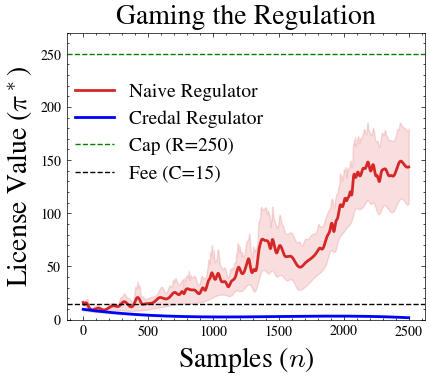

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline

try:
    plt.style.use(['science', 'no-latex'])
except:
    plt.style.use('default')

np.random.seed(42)

def solve_projection_hull(Q_hat, P_vertices):
    """
    Finds P* in the Convex Hull of P_vertices that minimizes KL(Q_hat || P*).
    """
    n_vertices = len(P_vertices)
    
    def objective(alpha):
        P_mix = np.dot(alpha, P_vertices)
        return -np.sum(Q_hat * np.log(P_mix + 1e-12))

    constraints = [
        {'type': 'eq', 'fun': lambda a: np.sum(a) - 1.0},
        {'type': 'ineq', 'fun': lambda a: a}
    ]
    
    x0 = np.ones(n_vertices) / n_vertices
    res = minimize(objective, x0, constraints=constraints, bounds=[(0,1)]*n_vertices)
    return np.dot(res.x, P_vertices)

def run_online_gaming_simulation():
    # --- 1. Distributions ---
    outcomes = [0, 1, 2]
    
    # Tiny Hull Configuration (Hard to detect)
    P1 = np.array([0.30, 0.35, 0.35])
    P2 = np.array([0.35, 0.30, 0.35])
    P3 = np.array([0.35, 0.35, 0.30])
    Vertices = np.array([P1, P2, P3])
    
    # --- 2. Simulation Params ---
    n_steps = 2500
    n_runs = 10
    C = 15.0
    R = 250.0
    update_freq = 10 
    
    # History stores the effective LICENSE value (capped at R)
    history_vertex = np.zeros((n_runs, n_steps))
    history_hull = np.zeros((n_runs, n_steps))
    
    print(f"Starting Simulation: Unbounded Evidence, Bounded License")

    for r in range(n_runs):
        # Internal UNBOUNDED wealth (Evidence)
        w_v_raw = C
        w_h_raw = C
        
        # Prior counts (Centered)
        counts = np.array([10.0, 10.0, 10.0]) 
        
        P_star_vertex = Vertices[0]
        P_star_hull = np.mean(Vertices, axis=0)
        
        # Gamer Strategy
        active_dist_indices = np.random.choice([0, 1, 2], size=n_steps)
        
        for t in range(n_steps):
            # --- A. ESTIMATION ---
            Q_hat = counts / counts.sum()
            
            if t % update_freq == 0:
                # Vertex Regulator Projection
                kls = [np.sum(Q_hat * np.log(Q_hat/p)) for p in Vertices]
                P_star_vertex = Vertices[np.argmin(kls)]
                
                # Hull Regulator Projection
                P_star_hull = solve_projection_hull(Q_hat, Vertices)
            
            # --- B. SAMPLING ---
            k = active_dist_indices[t]
            z = np.random.choice(outcomes, p=Vertices[k])
            
            # --- C. BETTING (Update Unbounded Evidence) ---
            
            # Naive (Vertex)
            payoff_v = Q_hat[z] / P_star_vertex[z]
            w_v_raw *= payoff_v
            
            # Robust (Hull)
            payoff_h = Q_hat[z] / P_star_hull[z]
            w_h_raw *= payoff_h
            
            # --- D. RECORD LICENSE VALUE (Capped) ---
            history_vertex[r, t] = min(w_v_raw, R)
            history_hull[r, t]   = min(w_h_raw, R)
            
            # --- E. UPDATE COUNTS ---
            counts[z] += 1

    # --- 3. Stats ---
    mean_vertex = np.mean(history_vertex, axis=0)
    std_vertex = np.std(history_vertex, axis=0)
    sem_vertex = std_vertex / np.sqrt(n_runs) # Standard Error
    
    mean_hull = np.mean(history_hull, axis=0)
    std_hull = np.std(history_hull, axis=0)
    sem_hull = std_hull / np.sqrt(n_runs) # Standard Error

    # --- 4. Spline Smoothing ---
    x_axis = np.arange(n_steps)
    
    # Define a helper to smooth via Spline (s controls smoothness)
    # s is set heuristically based on length to suppress high freq noise
    def smooth_spline(y, s_factor=5000):
        spl = UnivariateSpline(x_axis, y, s=s_factor)
        return spl(x_axis)

    # Smooth Means
    smooth_mean_v = smooth_spline(mean_vertex)
    smooth_mean_h = smooth_spline(mean_hull)
    
    # Smooth Bounds (Mean +/- SEM)
    smooth_upper_v = smooth_spline(mean_vertex + sem_vertex)
    smooth_lower_v = smooth_spline(mean_vertex - sem_vertex)
    
    smooth_upper_h = smooth_spline(mean_hull + sem_hull)
    smooth_lower_h = smooth_spline(mean_hull - sem_hull)

    # --- 5. Plotting ---
    plt.figure(figsize=(4.5, 4))
    
    # Naive Regulator
    plt.plot(x_axis, smooth_mean_v, color='#D62728', linewidth=2, label='Naive Regulator')
    plt.fill_between(x_axis, 
                     np.maximum(smooth_lower_v, 0.1), 
                     smooth_upper_v, 
                     color='#D62728', alpha=0.15)
    
    # Robust Regulator
    plt.plot(x_axis, smooth_mean_h, color='blue', linewidth=2, label='Credal Regulator')
    plt.fill_between(x_axis, 
                     np.maximum(smooth_lower_h, 0.1), 
                     smooth_upper_h, 
                     color='#2CA02C', alpha=0.15)
    
    plt.axhline(R, color='green', linestyle='--', label='Cap (R=250)')
    plt.axhline(C, color='black', linestyle='--', label='Fee (C=15)')
    
    plt.title("Gaming the Regulation", fontsize=20)
    plt.ylabel("License Value ($\pi^*$)", fontsize=20)
    plt.xlabel("Samples ($n$)", fontsize=20)
    plt.legend(loc=(0,0.45), fontsize=14)
    
    # Adjust limits to show the gap clearly
    plt.ylim(bottom=0, top=270)
    
    plt.tight_layout()
    plt.savefig("simulation.pdf")
    plt.show()
if __name__ == "__main__":
    run_online_gaming_simulation()